In [1]:
import os, json, math, random, csv
from typing import Dict
import numpy as np
import torch
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForQuestionAnswering,
    get_linear_schedule_with_warmup, AdamW, default_data_collator
)
import evaluate
from tqdm import tqdm
import matplotlib.pyplot as plt
def qa_eval_collate(features):
    
    keep_keys = ("example_id", "offset_mapping")
    model_features = [{k: v for k, v in f.items() if k not in keep_keys} for f in features]
    batch = default_data_collator(model_features)
    batch["example_id"] = [f["example_id"] for f in features]
    batch["offset_mapping"] = [f["offset_mapping"] for f in features]
    return batch



os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


cuda


In [2]:
train_path = "spoken_train-v1.1.json"
test_clean = "spoken_test-v1.1.json"
test_wer44 = "spoken_test-v1.1_WER44.json"
test_wer54 = "spoken_test-v1.1_WER54.json"

for p in [train_path, test_clean, test_wer44, test_wer54]:
    assert os.path.exists(p), f"Missing: {p}"

def load_spoken_squad_as_dataset(path: str) -> Dataset:
    """Parse SQuAD-style JSON → flat Dataset(id, context, question, answer_start, answer_text)"""
    with open(path, "r", encoding="utf-8") as f:
        js = json.load(f)
    ids, contexts, questions, answer_starts, answer_texts = [], [], [], [], []
    for art in js["data"]:
        for para in art["paragraphs"]:
            ctx = para["context"]
            for qa in para["qas"]:
                ans = qa["answers"][0]  # Spoken-SQuAD≈SQuAD v1 (single answer)
                ids.append(qa["id"])
                contexts.append(ctx)
                questions.append(qa["question"])
                answer_starts.append(ans["answer_start"])
                answer_texts.append(ans["text"])
    return Dataset.from_dict({
        "id": ids,
        "context": contexts,
        "question": questions,
        "answer_start": answer_starts,
        "answer_text": answer_texts
    })

raw = DatasetDict({
    "train": load_spoken_squad_as_dataset(train_path),
    "clean": load_spoken_squad_as_dataset(test_clean),
    "wer44": load_spoken_squad_as_dataset(test_wer44),
    "wer54": load_spoken_squad_as_dataset(test_wer54),
})
raw


DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answer_start', 'answer_text'],
        num_rows: 37111
    })
    clean: Dataset({
        features: ['id', 'context', 'question', 'answer_start', 'answer_text'],
        num_rows: 5351
    })
    wer44: Dataset({
        features: ['id', 'context', 'question', 'answer_start', 'answer_text'],
        num_rows: 5351
    })
    wer54: Dataset({
        features: ['id', 'context', 'question', 'answer_start', 'answer_text'],
        num_rows: 5351
    })
})

In [3]:
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"  # HW3-compliant (HF only)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)

MAX_LEN = 512
DOC_STRIDE = 128
PAD_ON_RIGHT = tokenizer.padding_side == "right"  # typically True


/home/kpatam/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another archit

In [4]:
def prepare_train_features(examples):
    questions = [q.strip() for q in examples["question"]]
    enc = tokenizer(
        questions if PAD_ON_RIGHT else examples["context"],
        examples["context"] if PAD_ON_RIGHT else questions,
        truncation="only_second" if PAD_ON_RIGHT else "only_first",
        max_length=MAX_LEN,
        stride=DOC_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_map = enc.pop("overflow_to_sample_mapping")
    offsets = enc.pop("offset_mapping")

    start_positions, end_positions = [], []
    for i, off in enumerate(offsets):
        sample_idx = sample_map[i]
        start_char = examples["answer_start"][sample_idx]
        end_char = start_char + len(examples["answer_text"][sample_idx])
        seq_ids = enc.sequence_ids(i)

        ctx_idx = 1 if PAD_ON_RIGHT else 0
        first_ctx = next(k for k, s in enumerate(seq_ids) if s == ctx_idx)
        last_ctx  = len(seq_ids) - 1 - next(k for k, s in enumerate(seq_ids[::-1]) if s == ctx_idx)

        cls_index = enc["input_ids"][i].index(tokenizer.cls_token_id)
        if not (off[first_ctx][0] <= start_char and off[last_ctx][1] >= end_char):
            start_positions.append(cls_index); end_positions.append(cls_index); continue

        # token start
        ts = first_ctx
        while ts <= last_ctx and off[ts][0] <= start_char:
            ts += 1
        ts -= 1
        # token end
        te = last_ctx
        while te >= first_ctx and off[te][1] >= end_char:
            te -= 1
        te += 1

        start_positions.append(ts)
        end_positions.append(te)

    enc["start_positions"] = start_positions
    enc["end_positions"] = end_positions
    return enc

def prepare_eval_features(examples):
    questions = [q.strip() for q in examples["question"]]
    enc = tokenizer(
        questions if PAD_ON_RIGHT else examples["context"],
        examples["context"] if PAD_ON_RIGHT else questions,
        truncation="only_second" if PAD_ON_RIGHT else "only_first",
        max_length=MAX_LEN,
        stride=DOC_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_map = enc.pop("overflow_to_sample_mapping")
    eids = []
    for i in range(len(enc["input_ids"])):
        seq_ids = enc.sequence_ids(i)
        off = enc["offset_mapping"][i]
        enc["offset_mapping"][i] = [
            o if seq_ids[k] == (1 if PAD_ON_RIGHT else 0) else None
            for k, o in enumerate(off)
        ]
        eids.append(examples["id"][sample_map[i]])
    enc["example_id"] = eids
    return enc

tokenized = {
    "train": raw["train"].map(prepare_train_features, batched=True, remove_columns=raw["train"].column_names),
    "clean": raw["clean"].map(prepare_eval_features, batched=True, remove_columns=raw["clean"].column_names),
    "wer44": raw["wer44"].map(prepare_eval_features, batched=True, remove_columns=raw["wer44"].column_names),
    "wer54": raw["wer54"].map(prepare_eval_features, batched=True, remove_columns=raw["wer54"].column_names),
}
{k: len(v) for k, v in tokenized.items()}


Map:   0%|          | 0/37111 [00:00<?, ? examples/s]

Map:   0%|          | 0/5351 [00:00<?, ? examples/s]

Map:   0%|          | 0/5351 [00:00<?, ? examples/s]

Map:   0%|          | 0/5351 [00:00<?, ? examples/s]

{'train': 37130, 'clean': 5376, 'wer44': 5376, 'wer54': 5376}

In [5]:
EPOCHS = 3
TRAIN_BS = 8
LR = 3e-5
WEIGHT_DECAY = 0.01
GRAD_ACCUM = 1

train_loader = DataLoader(tokenized["train"], batch_size=TRAIN_BS, shuffle=True, collate_fn=default_data_collator)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
num_update_steps_per_epoch = math.ceil(len(train_loader) / GRAD_ACCUM)
num_training_steps = EPOCHS * num_update_steps_per_epoch
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
model.train()

loss_history = []
start_acc_history, end_acc_history, joint_acc_history = [], [], []
epoch_index = []
global_step = 0

for epoch in range(EPOCHS):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    optimizer.zero_grad(set_to_none=True)
    for step, batch in enumerate(pbar):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out = model(**batch)
            loss = out.loss / GRAD_ACCUM

        # quick token-accuracy metrics (train-side)
        with torch.no_grad():
            sp = out.start_logits.argmax(dim=-1)
            ep = out.end_logits.argmax(dim=-1)
            st = batch["start_positions"]
            et = batch["end_positions"]
            s_acc = (sp == st).float().mean().item()
            e_acc = (ep == et).float().mean().item()
            j_acc = ((sp == st) & (ep == et)).float().mean().item()

        scaler.scale(loss).backward()
        if (step + 1) % GRAD_ACCUM == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1

        loss_history.append(float(loss.item() * GRAD_ACCUM))
        start_acc_history.append(s_acc); end_acc_history.append(e_acc); joint_acc_history.append(j_acc)

        pbar.set_postfix(
            loss=f"{loss_history[-1]:.4f}",
            s_acc=f"{s_acc:.3f}", e_acc=f"{e_acc:.3f}", j_acc=f"{j_acc:.3f}",
            lr=f"{scheduler.get_last_lr()[0]:.2e}"
        )
    epoch_index.append(len(loss_history))

# Save fine-tuned model
os.makedirs("bert_spoken_squad_finetuned", exist_ok=True)
model.save_pretrained("bert_spoken_squad_finetuned")
tokenizer.save_pretrained("bert_spoken_squad_finetuned")


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/local_scratch/slurm.6560844/ipykernel_1471217/2391543148.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
Epoch 1/3:   0%|          | 0/4642 [00:00<?, ?it/s]/local_scratch/slurm.6560844/ipykernel_1471217/2391543148.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Epoch 3/3: 100%|██████

('bert_spoken_squad_finetuned/tokenizer_config.json',
 'bert_spoken_squad_finetuned/special_tokens_map.json',
 'bert_spoken_squad_finetuned/vocab.txt',
 'bert_spoken_squad_finetuned/added_tokens.json',
 'bert_spoken_squad_finetuned/tokenizer.json')

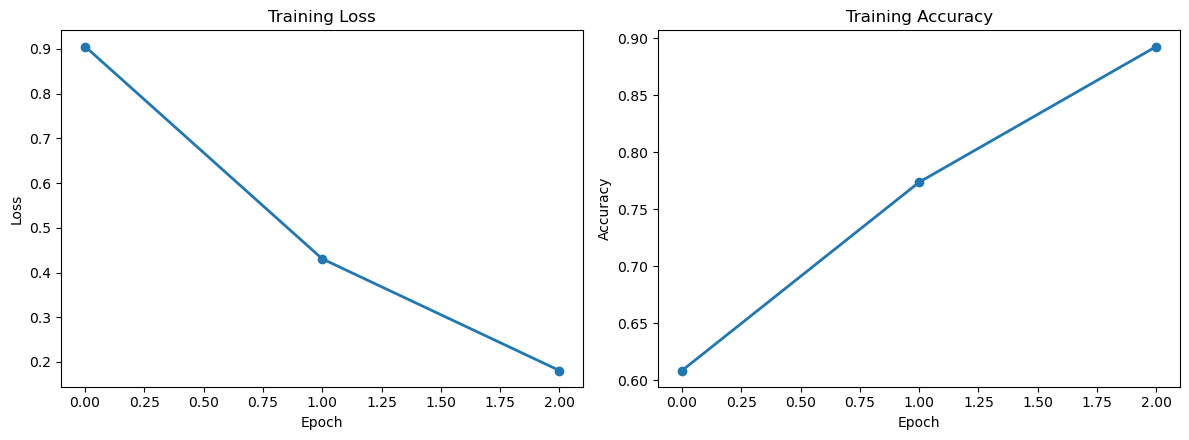

Saved: outputs/plots/training_epoch_curves.png


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("outputs/plots", exist_ok=True)

def _epoch_means(step_values, epoch_breaks):
    """Average per-step values into per-epoch means given epoch_end indices."""
    means = []
    start = 0
    for end in epoch_breaks:  # each 'end' is the step count *after* finishing that epoch
        chunk = step_values[start:end]
        means.append(float(np.mean(chunk)) if len(chunk) else np.nan)
        start = end
    return means

# Compute epoch-wise means
loss_per_epoch  = _epoch_means(loss_history,  epoch_index)
joint_per_epoch = _epoch_means(joint_acc_history, epoch_index)

# X-axis as epoch numbers: 0,1,2,...
epochs_x = list(range(len(loss_per_epoch)))


fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: Training Loss
axes[0].plot(epochs_x, loss_per_epoch, marker="o", linewidth=2)
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(False)

# Right: Training Accuracy (joint start&end)
axes[1].plot(epochs_x, joint_per_epoch, marker="o", linewidth=2)
axes[1].set_title("Training Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid(False)

plt.tight_layout()
out_path = "outputs/plots/training_epoch_curves.png"
plt.savefig(out_path, dpi=150)
plt.show()

print(f"Saved: {out_path}")


In [7]:
import re
import string
from collections import Counter
def _normalize(text: str) -> str:
    if text is None:
        return ""
    text = text.lower()
    text = "".join(ch for ch in text if ch not in set(string.punctuation))
    text = re.sub(r"\b(a|an|the)\b", " ", text)
    text = " ".join(text.split())
    return text

def _f1_score(pred: str, truth: str) -> float:
    pred_tokens  = _normalize(pred).split()
    truth_tokens = _normalize(truth).split()
    if len(pred_tokens) == 0 and len(truth_tokens) == 0:
        return 1.0
    common = Counter(pred_tokens) & Counter(truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0
    precision = num_same / len(pred_tokens)
    recall    = num_same / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

def _exact_match(pred: str, truth: str) -> float:
    return float(_normalize(pred) == _normalize(truth))

def compute_squad_metrics(predictions_list, references_list):
    """
    predictions_list: [{"id": "...", "prediction_text": "..."}]
    references_list : [{"id": "...", "answers": {"text":[text], "answer_start":[start]}}]
    Returns: {"exact_match": xx.x, "f1": yy.y}
    """
    ref_by_id = {ex["id"]: ex["answers"]["text"][0] for ex in references_list}
    em_total = 0.0
    f1_total = 0.0
    n = 0
    for p in predictions_list:
        pid = p["id"]
        pred_text = p["prediction_text"]
        truth_text = ref_by_id.get(pid, "")
        em_total += _exact_match(pred_text, truth_text)
        f1_total += _f1_score(pred_text, truth_text)
        n += 1
    if n == 0:
        return {"exact_match": 0.0, "f1": 0.0}
    return {"exact_match": 100.0 * em_total / n, "f1": 100.0 * f1_total / n}


In [8]:
def id2ctx_map(split_key: str) -> Dict[str, str]:
    return {i: c for i, c in zip(raw[split_key]["id"], raw[split_key]["context"])}

def predict_one_split(split_key: str, out_dir: str) -> Dict[str, float]:
    """Predict & score one split; saves predictions_*.json and metrics_*.txt"""
    os.makedirs(out_dir, exist_ok=True)
    eval_ds   = tokenized[split_key]
    raw_split = raw[split_key]
    id2ctx    = id2ctx_map(split_key)

    # use the custom collator here
    loader = DataLoader(eval_ds, batch_size=16, shuffle=False, collate_fn=qa_eval_collate)
    model.eval()

    all_start, all_end, all_eids, all_offsets = [], [], [], []
    with torch.no_grad():
        for batch in loader:  # plain loop (no tqdm, cleaner logs)
            eids = batch.pop("example_id")
            offsets = batch.pop("offset_mapping")
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            all_start.append(out.start_logits.detach().cpu().numpy())
            all_end.append(out.end_logits.detach().cpu().numpy())
            all_eids.extend(eids)
            all_offsets.extend(offsets)

    all_start = np.concatenate(all_start, axis=0)
    all_end   = np.concatenate(all_end,   axis=0)

    # n-best span search
    n_best, max_len = 20, 30
    preds_by_id = {}
    for s_log, e_log, eid, offs in zip(all_start, all_end, all_eids, all_offsets):
        s_idx = np.argsort(s_log)[-n_best:][::-1]
        e_idx = np.argsort(e_log)[-n_best:][::-1]
        best_text, best_score = "", -1e18
        for si in s_idx:
            for ei in e_idx:
                if si >= len(offs) or ei >= len(offs):         continue
                if offs[si] is None or offs[ei] is None:       continue
                if ei < si or (ei - si + 1) > max_len:         continue
                score = s_log[si] + e_log[ei]
                if score > best_score:
                    s_char, e_char = offs[si][0], offs[ei][1]
                    ctx = id2ctx[eid]
                    best_text, best_score = ctx[s_char:e_char], score
        preds_by_id[eid] = best_text

    refs = [{"id": i, "answers": {"text": [t], "answer_start": [s]}}
            for i, t, s in zip(raw_split["id"], raw_split["answer_text"], raw_split["answer_start"])]
    preds_list = [{"id": i, "prediction_text": preds_by_id.get(i, "")} for i in raw_split["id"]]

    with open(os.path.join(out_dir, f"predictions_{split_key}.json"), "w") as f:
        json.dump({p["id"]: p["prediction_text"] for p in preds_list}, f, indent=2)

    m = compute_squad_metrics(preds_list, refs)  # uses your local EM/F1
    with open(os.path.join(out_dir, f"metrics_{split_key}.txt"), "w") as f:
        f.write(f"{split_key}: EM={m['exact_match']:.2f}, F1={m['f1']:.2f}\n")

    return m


In [9]:
# Pretty names for printing
pretty = {
    "clean": "No Noise",
    "wer44": "WER 44",
    "wer54": "WER 54",
}

split_cfg = [("clean", "outputs/clean"),
             ("wer44", "outputs/wer44"),
             ("wer54", "outputs/wer54")]

split_results = {}

for key, outdir in split_cfg:
    print(f"Evaluating  {pretty[key]} test set...")
    split_results[key] = predict_one_split(key, outdir)

# Final report prints
print("\n Results:")
print("===================================\n")

for key in ["clean", "wer44", "wer54"]:
    res = split_results[key]
    print(f"Results for {pretty[key]}:")
    print(f"F1 Score: {res['f1']:.2f}%")
    print(f"EM Score: {res['exact_match']:.2f}%\n")

# Also save a combined CSV + JSON
os.makedirs("outputs", exist_ok=True)
with open("outputs/qa_results_splitwise.csv", "w", newline="") as f:
    w = csv.writer(f); w.writerow(["Split", "ExactMatch", "F1"])
    for k in ["clean", "wer44", "wer54"]:
        v = split_results[k]
        w.writerow([pretty[k], f"{v['exact_match']:.2f}", f"{v['f1']:.2f}"])

with open("outputs/qa_results_splitwise.json", "w") as f:
    json.dump(split_results, f, indent=2)


Evaluating  No Noise test set...
Evaluating  WER 44 test set...
Evaluating  WER 54 test set...

 Results:

Results for No Noise:
F1 Score: 76.65%
EM Score: 62.74%

Results for WER 44:
F1 Score: 54.89%
EM Score: 37.34%

Results for WER 54:
F1 Score: 41.62%
EM Score: 25.92%

